In [2]:
from smt.utils.sm_test_case import SMTestCase
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from smt.surrogate_models import KRG

from smt.applications.explainability_tools import ShapFeatureImportanceDisplay

from smt.problems import MixedCantileverBeam
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import MixedIntegerKrigingModel
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
import numpy as np
import unittest
import itertools
import random


class NumericalTestProblem:
    def __init__(self, num_samples):
        fun = WingWeight()
        sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
        x = sampling(num_samples)
        y = fun(x)

        feature_names = [
            r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$',
            r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$',
            r'$W_{dg}$', r'$W_{p}$',
        ]

        sm = KRG(
            theta0=[1e-2] * x.shape[1],
            print_prediction=False
        )
        sm.set_training_values(x, y)
        sm.train()

        self.model = sm
        self.x = x
        self.feature_names = feature_names


class MixedTestProblem:
    def __init__(self, num_samples):
        fun = MixedCantileverBeam()
        # Design space
        ds = DesignSpace([
            CategoricalVariable(values=[str(i + 1) for i in range(12)]),
            FloatVariable(10.0, 20.0),
            FloatVariable(1.0, 2.0),
        ])
        x = fun.sample(num_samples)
        y = fun(x)

        # Name of the features
        feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']
        # Index for categorical features
        categorical_feature_indices = [0]

        sm = MixedIntegerKrigingModel(
            surrogate=KPLS(
                design_space=ds,
                categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
                hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
                theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
                corr="squar_exp",
                n_start=1,
                cat_kernel_comps=[2],
                n_comp=2,
                print_global=False,
            ),
        )
        sm.set_training_values(x, np.array(y))
        sm.train()

        self.model = sm
        self.x = x
        self.feature_names = feature_names
        self.categorical_feature_indices = categorical_feature_indices

In [3]:
test_problem = NumericalTestProblem(300)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 300
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.4003041


In [4]:
shap_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    test_problem.model, 
    test_problem.x, 
    feature_names=test_problem.feature_names
)
fig = shap_importance.plot()
assert len(shap_importance.feature_importances) == test_problem.x.shape[1]

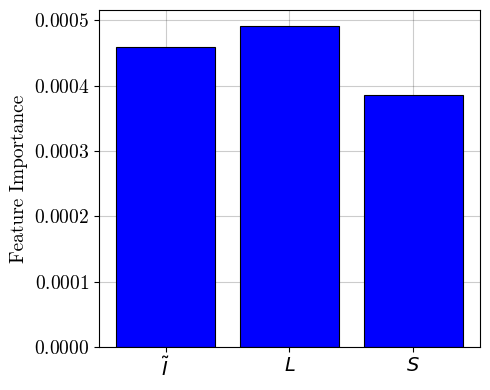

In [7]:
test_problem = MixedTestProblem(100)
shap_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    test_problem.model, 
    test_problem.x, 
    feature_names=test_problem.feature_names,
    categorical_feature_indices=test_problem.categorical_feature_indices,
)
fig = shap_importance.plot()
assert len(shap_importance.feature_importances) == test_problem.x.shape[1]
fig